# Key Concepts

* Key Components
    * Search Spaces
    * Trainables (objective function)
    * Search Algorithms
    * Schedulers
    * Trials
    * Analyses

* Overview: <br>
    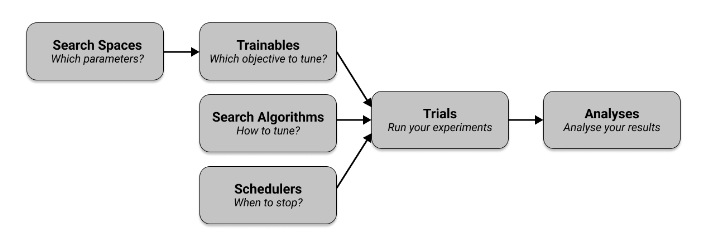 <br>



### Ray Tune Trainables

* A `Trainable` is an object that you can pass into a Tune run. Tune has 2 ways of defining a `trainable`: Function API and Class API. Trainables can return:
    * `train.report(...)`: Report the (intermediate) score to Tune. Do not use in Class Trainables.
    * `dict`: e.g., `{'score':score}`, simply return (or yield) the score at the end of the trainable function.

In [8]:
!ray stop

2024-11-09 16:22:34,088	INFO scripts.py:1197 -- Did not find any active Ray processes.


In [9]:
import ray

if ray.is_initialized():
    ray.shutdown()

context = ray.init()
#print(context.dashboard_url)

2024-11-09 16:22:46,219	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [10]:
from ray import train, tune

def objective(x, a, b):
    return a * (x ** 0.5) + b

def trainable(config: dict):
    intermediate_score = 0
    for x in range(20):
        intermediate_score = objective(x, config["a"], config["b"])
        train.report({"score": intermediate_score})  # This sends the score to Tune.


tuner = tune.Tuner(trainable, param_space={"a": 2, "b": 4})
results = tuner.fit()

2024-11-09 16:23:23,020	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-09_16-22-56' in 0.0118s.
2024-11-09 16:23:23,037	INFO tune.py:1041 -- Total run time: 26.42 seconds (5.47 seconds for the tuning loop).


In [11]:
!ray summary tasks


======== Tasks Summary: 2024-11-09 16:23:33.426840 ========
Stats:
------------------------------------
total_actor_scheduled: 1
total_actor_tasks: 24
total_tasks: 1


Table (group by func_name):
------------------------------------
    FUNC_OR_CLASS_NAME                    STATE_COUNTS    TYPE
0   ImplicitFunc.train                    FINISHED: 21    ACTOR_TASK
1   ImplicitFunc.get_auto_filled_metrics  FINISHED: 1     ACTOR_TASK
2   ImplicitFunc.__ray_ready__            FINISHED: 1     ACTOR_TASK
3   bundle_reservation_check_func         FINISHED: 1     NORMAL_TASK
4   ImplicitFunc.stop                     FINISHED: 1     ACTOR_TASK
5   ImplicitFunc.__init__                 FINISHED: 1     ACTOR_CREATION_TASK



### Ray Tune Search Spaces
* A search space defines valid values for your hyperparameters and can specify how these values are sampled (e.g. from a uniform distribution or a normal distribution).
* Tune offers various functions to define search spaces and sampling methods: [Link](https://docs.ray.io/en/latest/tune/api/search_space.html#tune-search-space)

In [12]:
config = {
    # Sample a float uniformly between -5.0 and -1.0
    "uniform": tune.uniform(-5, -1),

    # Sample a float uniformly between 3.2 and 5.4,
    # rounding to multiples of 0.2
    "quniform": tune.quniform(3.2, 5.4, 0.2),

    # Sample a float uniformly between 0.0001 and 0.01, while
    # sampling in log space
    "loguniform": tune.loguniform(1e-4, 1e-2),

    # Sample a float uniformly between 0.0001 and 0.1, while
    # sampling in log space and rounding to multiples of 0.00005
    "qloguniform": tune.qloguniform(1e-4, 1e-1, 5e-5),

    # Sample a random float from a normal distribution with
    # mean=10 and sd=2
    "randn": tune.randn(10, 2),

    # Sample a random float from a normal distribution with
    # mean=10 and sd=2, rounding to multiples of 0.2
    "qrandn": tune.qrandn(10, 2, 0.2),

    # Sample a integer uniformly between -9 (inclusive) and 15 (exclusive)
    "randint": tune.randint(-9, 15),

    # Sample a random uniformly between -21 (inclusive) and 12 (inclusive (!))
    # rounding to multiples of 3 (includes 12)
    # if q is 1, then randint is called instead with the upper bound exclusive
    "qrandint": tune.qrandint(-21, 12, 3),

    # Sample a integer uniformly between 1 (inclusive) and 10 (exclusive),
    # while sampling in log space
    "lograndint": tune.lograndint(1, 10),

    # Sample a integer uniformly between 1 (inclusive) and 10 (inclusive (!)),
    # while sampling in log space and rounding to multiples of 2
    # if q is 1, then lograndint is called instead with the upper bound exclusive
    "qlograndint": tune.qlograndint(1, 10, 2),

    # Sample an option uniformly from the specified choices
    "choice": tune.choice(["a", "b", "c"]),

    # Sample from a random function, in this case one that
    # depends on another value from the search space
    "func": tune.sample_from(lambda spec: spec.config.uniform * 0.01),

    # Do a grid search over these values. Every value will be sampled
    # ``num_samples`` times (``num_samples`` is the parameter you pass to ``tune.TuneConfig``,
    # which is taken in by ``Tuner``)
    "grid": tune.grid_search([32, 64, 128])
}

### Tune Trials

* use `Tuner.fit(...)` to execute and manage hyperparameter tuning and generate your `trials`.
    * At a minimum, your `Tuner` call takes in a trainable as first argument, and a `param_space` dictionary to define the search space.
    * It also provides many features such as logging, checkpointing, and early stopping.
    * It will generate a couple of hyperparameter configurations from its arguments, wrapping them into `Trial` objects.
        * A `Trial` object holds the state for one model training run.

In [13]:
space = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 1)}
tuner = tune.Tuner(
    trainable, param_space=space, tune_config=tune.TuneConfig(num_samples=10)
)
tuner.fit()

results = tuner.fit()

2024-11-09 16:23:56,095	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-09_16-23-33' in 0.0434s.
2024-11-09 16:23:56,143	INFO tune.py:1041 -- Total run time: 10.80 seconds (10.68 seconds for the tuning loop).


In [14]:
print(
    results.get_best_result(metric='score', mode='min').config
)

{'a': 0.06751370179587857, 'b': 0.010990081993636047}


### Tune Search Algorithms

* Default Search Algorithm is random
* [Available search algorithms in Tune](https://docs.ray.io/en/latest/tune/key-concepts.html)
* [Search Algorithms APIs](https://docs.ray.io/en/latest/tune/api/suggestion.html#tune-search-alg)

In [15]:
from ray.tune.search.optuna import OptunaSearch

In [16]:
search_space = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 20)}

algo = OptunaSearch()

tuner = tune.Tuner(
    trainable,
    tune_config=tune.TuneConfig(
        metric='score', mode='min', search_alg=algo
    ),
    run_config=train.RunConfig(stop={'training_iteration':20}),
    param_space=search_space
)

tuner.fit()

2024-11-09 16:24:02,048	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-09_16-23-57' in 0.0129s.
2024-11-09 16:24:02,065	INFO tune.py:1041 -- Total run time: 4.67 seconds (4.63 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'score': 5.660905081896003},
    path='C:/Users/JCA/ray_results/trainable_2024-11-09_16-23-57/trainable_2cb6e7d4_1_a=0.2560,b=4.5450_2024-11-09_16-23-57',
    filesystem='local',
    checkpoint=None
  )
]>

### Tune Schedulers

* Trial Scheduler from `ray.tune.schedulers`:
    * Default is scheduler is FIFO (first-in first-out) scheduler, w/c simply passes through the trials selected by your search algorithm in the order they were picked and does not perform any early stopping.
    * Trial Schedulers can early terminate bad trials, pause trials, clone trials, and alter hyperparameters of a running trial.
    * All Trial Schedulers take in a metric, which is a value returned in the result dict of your Trainable and is maximized or minimized according to mode.
    * Certain schedulers cannot be used with search algorithms, and certain schedulers require that you implement checkpointing.
    * Schedulers can dynamically change trial resource requirements during tuning. This is implemented in `ResourceChangingScheduler`, which can wrap around any other scheduler. <br>
    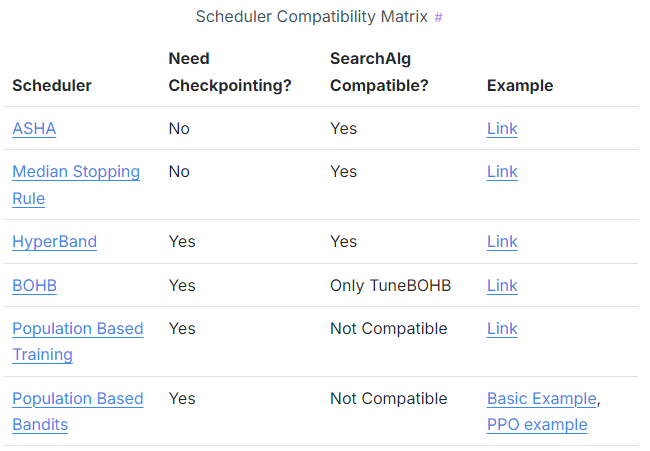 <br>


In [17]:
from ray.tune.schedulers import HyperBandScheduler

def objective(x, a, b):
    return a * (x ** 0.5) + b

def trainable(config: dict):
    intermediate_score = 0
    for x in range(20):
        intermediate_score = objective(x, config["a"], config["b"])
        train.report({"score": intermediate_score})  # This sends the score to Tune.

# Create HyperBand scheduler and minimize the "score" from trainable
hyperband = HyperBandScheduler()
search_algo = OptunaSearch()

config = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 1)}

tuner = tune.Tuner(
    trainable,
    tune_config=tune.TuneConfig(
        metric='score',
        mode='min',
        num_samples=20,
        scheduler=hyperband,
        search_alg=search_algo
    ),
    param_space=config,
)
result = tuner.fit()

2024-11-09 16:25:34,591	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-09_16-24-02' in 0.0534s.
2024-11-09 16:25:34,610	INFO tune.py:1041 -- Total run time: 92.52 seconds (92.43 seconds for the tuning loop).


In [18]:
result.get_best_result('score', 'max')

Result(
  metrics={'score': 4.861875332680363},
  path='C:/Users/JCA/ray_results/trainable_2024-11-09_16-24-02/trainable_0ba7eb13_10_a=0.8903,b=0.9810_2024-11-09_16-24-43',
  filesystem='local',
  checkpoint=None
)

In [19]:
result.get_dataframe().sort_values(by='score', ascending=False).head(3)

,score,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/a,config/b,logdir
9,4.861875,1731140688,None,False,20,0ba7eb13,2024-11-09_16-24-48,0.0,0.004513,19896,JCA,127.0.0.1,0.004513,20,0.890345,0.980951,0ba7eb13
10,4.629007,1731140693,None,False,20,15f33cc4,2024-11-09_16-24-53,0.0,0.002011,21984,JCA,127.0.0.1,0.002011,20,0.952107,0.478871,15f33cc4
1,3.690396,1731140651,None,False,20,b15e80bf,2024-11-09_16-24-11,0.0,0.004253,31852,JCA,127.0.0.1,0.004253,20,0.645433,0.877020,b15e80bf


### Tune Result Grid

* `Tuner.fit()` returns an `ResultGrid` object w/c has methods you can use for analyzing your training.

In [20]:
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotated',
 '_annotated_api_group',
 '_annotated_type',
 '_experiment_analysis',
 '_populate_exception',
 '_results',
 '_trial_to_result',
 'errors',
 'experiment_path',
 'filesystem',
 'get_best_result',
 'get_dataframe',
 'num_errors',
 'num_terminated']

# Logging and Outputs in `Tune`

*  By default, Tune logs results for TensorBoard, CSV, and JSON formats.
* [Logging lower level (model weights or gradients)](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html#trainable-logging)
* [Logging and Customizations](https://docs.ray.io/en/latest/tune/api/logging.html#loggers-docstring)

### Configure logging in `Tune`

* `Tune` will log the results of each trial to a sub-folder under a specified local dir, w/c defaults to `~/ray_results`.

In [30]:
import pathlib

In [35]:
config = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 1)}
hyperband = HyperBandScheduler()
search_algo = OptunaSearch()

tuner = tune.Tuner(
    trainable=trainable,
    tune_config=tune.TuneConfig(
        metric='score',
        mode='min',
        scheduler=hyperband,
        search_alg=search_algo,
        num_samples=3
    ),
    run_config=train.RunConfig(
        storage_path=f'{pathlib.Path().resolve()}\\log_results',
        name='test_experiement'
    ),
    param_space=config
)

results = tuner.fit()

2024-11-09 17:24:19,704	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/Notes/git local repo/Diabetes Health Indicator/scaling/ray/tune/log_results/test_experiement' in 0.0179s.
2024-11-09 17:24:19,725	INFO tune.py:1041 -- Total run time: 14.55 seconds (14.50 seconds for the tuning loop).


# Parallelism and Resources for Ray Tune

* Parallelism is determined by per trial resources (defaulting to 1 CPU, 0 GPU per trial) and the resources available to Tune (`ray.cluster_resources()`).

* By default, Tune automatically runs N concurrent trials, where N is the number of CPUs on your machine.
* You can override this per trial resources w/ `tune.with_resources()`. 
    * Specify your resource requests using either a dictionary or a `PlacementGroupFactory` object.

* `tune.with_resources` cannot be used w/ Ray Train Trainers.
    * If you are passing a Trainer to a Tuner, specify the resource requirements in the Trainer instance using `ScalingConfig`

In [38]:
ray.cluster_resources()

{'accelerator_type:G': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 12.0,
 'memory': 4253336372.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 2126668185.0,
 'GPU': 1.0}

### GPUs in Tune:



In [ ]:
config = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 1)}
hyperband = HyperBandScheduler()
search_algo = OptunaSearch()




trainable_gpu = tune.with_resources(trainable, {'gpu':1})

tuner = tune.Tuner(
    trainable=trainable_gpu,
    tune_config=tune.TuneConfig(
        metric='score',
        mode='min',
        scheduler=hyperband,
        search_alg=search_algo,
        num_samples=3
    ),
    param_space=config
)

results = tuner.fit()

2024-11-09 17:40:34,642	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-09_17-40-15' in 0.0179s.
2024-11-09 17:40:34,660	INFO tune.py:1041 -- Total run time: 19.04 seconds (18.99 seconds for the tuning loop).


In [42]:
config = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 1)}
hyperband = HyperBandScheduler()
search_algo = OptunaSearch()

# GPU + CPU
trainable_gpu = tune.with_resources(trainable, {"cpu": 2, "gpu": 1})

tuner = tune.Tuner(
    trainable=trainable_gpu,
    tune_config=tune.TuneConfig(
        metric='score',
        mode='min',
        scheduler=hyperband,
        search_alg=search_algo,
        num_samples=10
    ),
    param_space=config
)

results = tuner.fit()

2024-11-09 18:06:10,318	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-09_18-05-19' in 0.0300s.
2024-11-09 18:06:10,334	INFO tune.py:1041 -- Total run time: 50.92 seconds (50.85 seconds for the tuning loop).


In [43]:
results.get_dataframe().sort_values(by='score', ascending=False).head(3)

,score,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/a,config/b,logdir
2,4.677958,1731146733,None,False,20,91921ca6,2024-11-09_18-05-33,0.0,0.004992,29324,JCA,127.0.0.1,0.004992,20,0.922704,0.655987,91921ca6
0,4.318485,1731146724,None,False,20,40c50cff,2024-11-09_18-05-24,0.0,0.002006,25948,JCA,127.0.0.1,0.002006,20,0.841446,0.650706,40c50cff
7,4.030175,1731146759,None,False,20,9b360c2c,2024-11-09_18-05-59,0.0,0.005872,30676,JCA,127.0.0.1,0.005872,20,0.834985,0.390559,9b360c2c


# Stopping Criteria for a Ray Tune Experiment

* Stopping criteria in Tune can be useful for terminating training based on specific conditions.
* For instance:
    1. Set up an experiment to end after N epochs or when the reported evaluation score surpasses a particular threshold, w/c ever occurs first.
    2. Stop the experiment after T seconds.
    3. Terminate when trials encounter runtime errors.
    4. Stop underperforming trials early by utilizing Tune’s early-stopping schedulers.


In [44]:
import time

def my_trainable(config):
    i = 1
    while True:
        # Do some training...
        time.sleep(1)

        # Report some metrics for demonstration...
        train.report({"mean_accuracy": min(i / 10, 1.0)})
        i += 1

### Stop a Tune Experiment Manually

* If you send a `SIGINT` signal to the process running `Tuner.fit()` (which is usually what happens when you press `Ctrl+C` in the terminal), Ray Tune shuts down training gracefully and saves the final experiment state.
* Ray Tune also accepts the `SIGUSR1` signal to interrupt training gracefully. This should be used when running Ray Tune in a remote Ray task as Ray will filter out `SIGINT` and `SIGTERM` signals per default. (linux or powershell)
    ```bash
    kill(pid, SIGUSR1)
    ```

### Stop using metric-based criteria

* These are a fixed set of thresholds that determine when the experiment should stop.
* You can implement the stopping criteria using either a dictionary, a function, or a custom [`Stopper`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.stopper.Stopper.html#ray.tune.stopper.Stopper)

* Dictionary:
    * If a dictionary is passed in, the keys may be any field in the return result of `session.report` in the Function API or `step()` in the Class API.

* UDF
    * For more flexibility, you can pass in a function instead. If a function is passed in, it must take (`trial_id:str, result:dict`) as arguments and return a boolean (`True` if trial should be stopped and `False` otherwise).
    

* Custom Stopper Class
    * Using the `Stopper` interface for stopping individual trials or even entire experiments based on custom stopping criteria.

In [46]:
# Resources
trainable_gpu = tune.with_resources(my_trainable, {"gpu": 1})
trainable_gpu_cpu = tune.with_resources(my_trainable, {"cpu": 2, "gpu": 1})

In [45]:
# DICTIONARY
# Each Trial will be stopped either when it completes 10 iterations or when it reaches a mean accuracy of 0.8 or more.
tuner = tune.Tuner(
    my_trainable,
    run_config=train.RunConfig(stop={"training_iteration": 10, 
                                     "mean_accuracy": 0.8}),
)

result_grid = tuner.fit()

2024-11-09 20:30:58,944	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/my_trainable_2024-11-09_20-30-26' in 0.0123s.
2024-11-09 20:30:58,959	INFO tune.py:1041 -- Total run time: 32.22 seconds (32.17 seconds for the tuning loop).


In [52]:
#UDF
def stop_fn(trial_id:str, result:dict) -> bool:
    x = result['mean_accuracy'] >= 0.8 or result['training_iteration'] >= 10
    return x

tuner = tune.Tuner(
    trainable_gpu,
    run_config=train.RunConfig(stop=stop_fn)
)
result_grid = tuner.fit()

2024-11-09 20:36:41,770	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/my_trainable_2024-11-09_20-36-28' in 0.0100s.
2024-11-09 20:36:41,787	INFO tune.py:1041 -- Total run time: 12.99 seconds (12.94 seconds for the tuning loop).


In [54]:
#CLASS
from ray.tune import Stopper

class CustomStopper(Stopper):
    def __init__(self):
        self.should_stop = False
    
    def __call__(self, trial_id:str, result:dict) -> bool:
        if not self.should_stop and result['mean_accuracy'] >= 0.8:
            self.should_stop = True
        return self.should_stop
    
    def stop_all(self) -> bool:
        """Returns whether to stop trials and prevent new ones from starting."""
        return self.should_stop
    
stopper = CustomStopper()
tuner = tune.Tuner(
    trainable_gpu_cpu,
    run_config = train.RunConfig(stop=stopper),
    tune_config=tune.TuneConfig(num_samples=2)
)

result_grid = tuner.fit()

2024-11-09 20:43:02,495	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/my_trainable_2024-11-09_20-42-49' in 0.0130s.
2024-11-09 20:43:02,511	INFO tune.py:1041 -- Total run time: 12.69 seconds (12.64 seconds for the tuning loop).
2024-11-09 20:43:02,519	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- my_trainable_2109c_00001: FileNotFoundError('Could not fetch metrics for my_trainable_2109c_00001: both result.json and progress.csv were not found at C:/Users/JCA/ray_results/my_trainable_2024-11-09_20-42-49/my_trainable_2109c_00001_1_2024-11-09_20-42-49')


### Stop trials after a certain amount of time

* There are two choices to stop a Tune experiment based on time: 
    * stopping trials individually after a specified timeout, or ;
    * stopping the full experiment after a certain amount of time.

In [58]:
# stopping trials individually after a specified timeout
tuner = tune.Tuner(
    my_trainable,
    # Stop a trial after it's run for more than 5 seconds.
    run_config=train.RunConfig(stop={"time_total_s": 5}),
    tune_config=tune.TuneConfig(num_samples=3)
    
)
result_grid = tuner.fit()

2024-11-09 20:54:44,976	WARNING util.py:201 -- The `process_trial_result` operation took 0.501 s, which may be a performance bottleneck.
2024-11-09 20:54:44,978	WARNING util.py:201 -- Processing trial results took 0.503 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-11-09 20:54:44,978	WARNING util.py:201 -- The `process_trial_result` operation took 0.503 s, which may be a performance bottleneck.
2024-11-09 20:54:45,999	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/my_trainable_2024-11-09_20-54-15' in 0.0139s.
2024-11-09 20:54:46,014	INFO tune.py:1041 -- Total run time: 30.13 seconds (30.08 seconds for the tuning loop).


In [59]:
# Stop the experiment with a timeout
# Stop the entire experiment after ANY trial has run for more than 5 seconds.
tuner = tune.Tuner(my_trainable, tune_config=tune.TuneConfig(time_budget_s=5.0))
result_grid = tuner.fit()

2024-11-09 20:55:51,649	INFO timeout.py:54 -- Reached timeout of 5.0 seconds. Stopping all trials.
2024-11-09 20:55:51,674	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/my_trainable_2024-11-09_20-55-46' in 0.0095s.
2024-11-09 20:55:52,006	INFO tune.py:1041 -- Total run time: 5.60 seconds (5.24 seconds for the tuning loop).


### Stop on trial failures

* In addition to stopping trials based on their performance, you can also stop the entire experiment if any trial encounters a runtime error. 
    * To do this, you can use the `ray.train.FailureConfig` class.
    * This is useful when you are debugging a Tune experiment with many trials.


In [60]:
def my_failing_trainable(config):
    if config["should_fail"]:
        raise RuntimeError("Failing (on purpose)!")
    # Do some training...
    time.sleep(10)
    train.report({"mean_accuracy": 0.9})


tuner = tune.Tuner(
    my_failing_trainable,
    param_space={"should_fail": tune.grid_search([True, False])},
    run_config=train.RunConfig(failure_config=train.FailureConfig(fail_fast=True)),
)
result_grid = tuner.fit()

2024-11-09 20:57:55,269	ERROR tune_controller.py:1331 -- Trial task failed for trial my_failing_trainable_3980f_00000
Traceback (most recent call last):
  File "d:\Miniconda\envs\mle_proj\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "d:\Miniconda\envs\mle_proj\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "d:\Miniconda\envs\mle_proj\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\Miniconda\envs\mle_proj\Lib\site-packages\ray\_private\worker.py", line 2745, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Miniconda\envs\mle_proj\Lib\site-pa

### Early stopping with Tune schedulers

* Using early Stopping schedulers

In [61]:
from ray.tune.schedulers import AsyncHyperBandScheduler

scheduler = AsyncHyperBandScheduler(time_attr="training_iteration")

tuner = tune.Tuner(
    my_trainable,
    run_config=train.RunConfig(stop={"training_iteration": 10}),
    tune_config=tune.TuneConfig(
        scheduler=scheduler, num_samples=2, metric="mean_accuracy", mode="max"
    ),
)
result_grid = tuner.fit()

2024-11-09 21:00:34,177	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/my_trainable_2024-11-09_21-00-04' in 0.0120s.
2024-11-09 21:00:34,191	INFO tune.py:1041 -- Total run time: 30.17 seconds (30.13 seconds for the tuning loop).


# Checkpointing

* User-defined and are meant to snapshot your training progress.
* Trial level checkpoints are saved via the `Tune Trainable` API:
    *  This is how you define your custom training logic, and it’s also where you’ll define which trial state to checkpoint.

### Function API Checkpointing

* To create a checkpoint, use the `from_directory()` APIs.
    ```python
    import os
    import tempfile

    from ray import train, tune
    from ray.train import Checkpoint


    def train_func(config):
        start = 1
        my_model = MyModel()

        checkpoint = train.get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
                start = checkpoint_dict["epoch"] + 1
                my_model.load_state_dict(checkpoint_dict["model_state"])

        for epoch in range(start, config["epochs"] + 1):
            # Model training here
            # ...

            metrics = {"metric": 1}
            with tempfile.TemporaryDirectory() as tempdir:
                torch.save(
                    {"epoch": epoch, "model_state": my_model.state_dict()},
                    os.path.join(tempdir, "checkpoint.pt"),
                )
                train.report(metrics=metrics, checkpoint=Checkpoint.from_directory(tempdir))


    tuner = tune.Tuner(train_func, param_space={"epochs": 5})
    result_grid = tuner.fit()
    ```

### Class API Checkpointing

```python
import os
import torch
from torch import nn

from ray import train, tune


class MyTrainableClass(tune.Trainable):
    def setup(self, config):
        self.model = nn.Sequential(
            nn.Linear(config.get("input_size", 32), 32), nn.ReLU(), nn.Linear(32, 10)
        )

    def step(self):
        return {}

    def save_checkpoint(self, tmp_checkpoint_dir):
        checkpoint_path = os.path.join(tmp_checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return tmp_checkpoint_dir

    def load_checkpoint(self, tmp_checkpoint_dir):
        checkpoint_path = os.path.join(tmp_checkpoint_dir, "model.pth")
        self.model.load_state_dict(torch.load(checkpoint_path))


tuner = tune.Tuner(
    MyTrainableClass,
    param_space={"input_size": 64},
    run_config=train.RunConfig(
        stop={"training_iteration": 2},
        checkpoint_config=train.CheckpointConfig(checkpoint_frequency=2),
    ),
)
tuner.fit()
```

##### Manual Checkpointing

In [64]:
import random


# to be implemented by user.
def detect_instance_preemption():
    choice = random.randint(1, 100)
    # simulating a 1% chance of preemption.
    return choice <= 1


def train_func(self):
    # training code
    result = {"mean_accuracy": "my_accuracy"}
    if detect_instance_preemption():
        result.update(should_checkpoint=True)
    return result


##### Periodic Checkpointing

```python
    tuner = tune.Tuner(
        MyTrainableClass,
        run_config=train.RunConfig(
            stop={"training_iteration": 2},
            checkpoint_config=train.CheckpointConfig(checkpoint_frequency=10),
        ),
    )
    tuner.fit()
```

##### Checkpointing at Termination

```python
    tuner = tune.Tuner(
        MyTrainableClass,
        run_config=train.RunConfig(
            stop={"training_iteration": 2},
            checkpoint_config=train.CheckpointConfig(
                checkpoint_frequency=10, checkpoint_at_end=True
            ),
        ),
    )
    tuner.fit()
```


### Getting Data out of Ray Tune

